# py_regularization.ipynb

## Lecture 6 of CMU16-745 (2025)

Use JAX for automatic differentiation

Feb 14, 25 : Refine code.

*  No need to use wrapper function for jax.jacfwd() anymore.
*  Add reshape(2,1) to input x 


In [435]:
import numpy as np 
import matplotlib.pyplot as plt 
from jax.numpy.linalg import norm, solve, eig
import jax
import jax.numpy as jnp

In [436]:
Q = np.diag([0.5,1])
Q
# objective function
def f(x):
    x1 = jnp.array(x) - jnp.array([[1],[0]])
    return 0.5*(x1.T@Q@x1)[0,0]

# gradient 
def df(x):
    x1 = np.array(x) - np.array([[1],[0]])
    return Q@x1

# hessian 
def d2f(x):
    return Q


In [437]:
# constraint and gradient (improved)

def c(x):
    return (x[0]**2 + 2*x[0] - x[1]).item()  # correction to return scalar value

def dc(x):
    return jnp.asarray([2*x[0]+2, [-1]]).reshape(1,2) # minor correction to return clean array


In [438]:
def newton_step(x0,lambda0):
    H = d2f(x0) + jnp.asarray((jax.jacfwd(dc)(x0)).T*lambda0).reshape(2,2)   
    #C = jnp.expand_dims(jnp.asarray(dc(x0)), axis=0)
    C = dc(x0)
    A = jnp.vstack((jnp.hstack((H,C.T)),jnp.hstack((C,jnp.zeros((1,1))))))
    #x0a = jnp.expand_dims(x0,axis=1)
    B = jnp.vstack((-df(x0)-C.T*lambda0, -jnp.asarray(c(x0))))
    dz = solve(A,B)
    dx = dz[0:2]
    dlambda = dz[2]
    return x0+dx, lambda0+dlambda
    

In [439]:
def plot_steps(xguess,i):
    ax = plot_landscape()
    ax.scatter(xguess[0,:], xguess[1,:],marker='x',color='g') 
    ax.scatter(xguess[0,-1], xguess[1,-1],marker='x',color='r')
    for ix in range(xguess.shape[1]-1):
        x1_old = xguess[0,ix]
        x1_new = xguess[0,ix+1]
        x2_old = xguess[1,ix]
        x2_new = xguess[1,ix+1]
        if jnp.linalg.norm(xguess[:,ix] - xguess[:,ix+1]).item() > 0.1: # plot arrow if distance large enough
            ax.arrow(x1_old,x2_old,(x1_new-x1_old)/2,(x2_new-x2_old)/2,head_width=0.1,color='m')
    ax.plot(xguess[0,:], xguess[1,:],'m')   
    ax.set_title("Iteration : " + str(i))

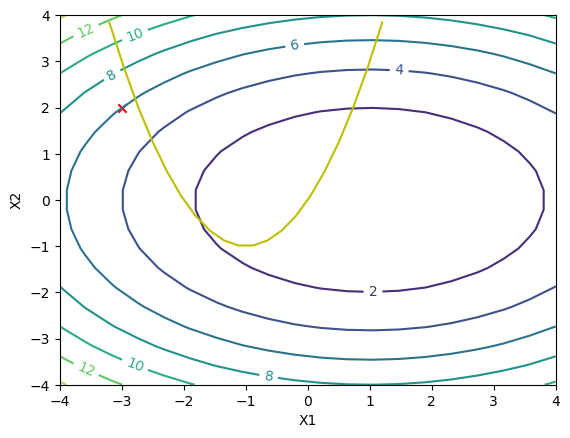

In [446]:
xguess = jnp.array([[-3.0],[2.0]])
lambdaguess = [0.0]
i=0
ax = plot_landscape()
ax.scatter(xguess[0], xguess[1],marker='x',color='r')

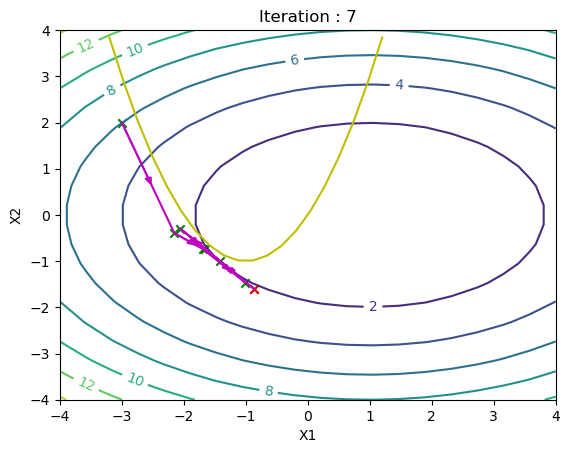

In [453]:
xnew, lambdanew = newton_step(xguess[:,-1].reshape(2,1),lambdaguess[-1])
xguess = jnp.hstack((xguess, xnew))
lambdaguess.append(lambdanew)
i+=1
plot_steps(xguess,i)

In [454]:
xr = xguess[:,-1].reshape(2,1)
H = d2f(xr) + jnp.asarray((jax.jacfwd(dc)(xr)).T*lambdaguess[-1]).reshape(2,2)
C = dc(xr)
#C = jnp.expand_dims(jnp.asarray(dc(xguess[:,-1])), axis=0)
A = jnp.vstack((jnp.hstack((H,C.T)),jnp.hstack((C,jnp.zeros((1,1))))))
evalA, evecA = eig(A)
evalA

Array([-2.7504282 +0.j, -0.59146094+0.j,  1.6230594 +0.j], dtype=complex64)

In [443]:
def regularized_newton_step(x0,lambda0):

    lambdalen = len(lambda0)
    xlen = len(x0)
    beta = 1.0
    H = d2f(x0) + jnp.asarray((jax.jacfwd(dc)(x0)).T*lambda0).reshape(2,2)
    C = dc(x0)
    A = jnp.vstack((jnp.hstack((H,C.T)),jnp.hstack((C,jnp.zeros((1,1))))))
    evalA, evecA = eig(A)
    Rx = beta*np.ones((xlen))
    Rl = -beta*np.ones((lambdalen))
    R = np.diag(np.hstack((Rx,Rl)))    
    while not (sum(evalA>0)==xlen and sum(evalA<0)==lambdalen):
        A += R
        evalA, evecA = eig(A)
    #x0a = jnp.expand_dims(x0,axis=1)
    B = jnp.vstack((-df(x0)-C.T*lambda0, -jnp.asarray(c(x0))))
    dz = solve(A,B)
    dx = dz[0:2]
    dlambda = dz[2]
    return x0+dx, lambda0+dlambda
    

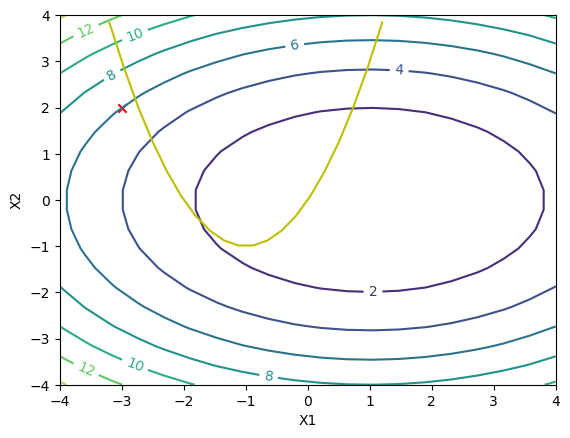

In [455]:
xguess = jnp.array([[-3.0],[2.0]])
lambdaguess = jnp.array([[0.0]])
i = 0
ax = plot_landscape()
ax.scatter(xguess[0], xguess[1],marker='x',color='r')

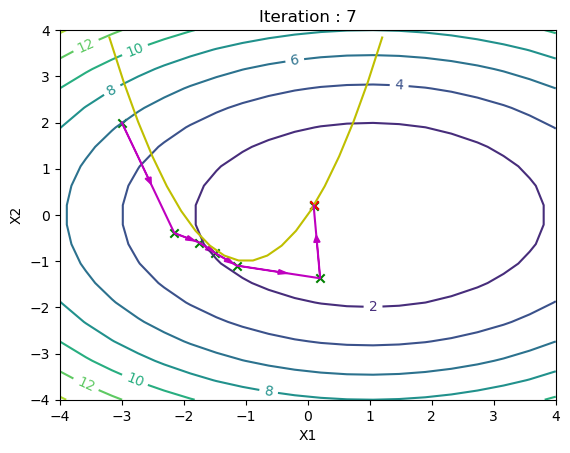

In [462]:
xnew, lambdanew = regularized_newton_step(xguess[:,-1].reshape(2,1),lambdaguess[-1])
xguess = jnp.hstack((xguess, xnew))
jnp.append(lambdaguess, lambdanew)
#lambdaguess.append(lambdanew)
i+=1
plot_steps(xguess,i)